In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append('..')
from dataset import batcher

In [4]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [12]:
# Get test split
test_batcher = batcher.Batcher(bucket=False, shuffle=False, split='test', repeat=1, batch_size=652).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 1)


In [13]:
# Load model
experiments = ['imagery_sample_vgg_regression_temp']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [14]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-02-11 14:46:47.582530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[ 1.88109204e-02]
 [ 6.26047254e-01]
 [ 1.93996797e-03]
 [-1.77049547e-01]
 [ 9.24648046e-01]
 [ 7.93082476e-01]
 [ 1.26747966e+00]
 [ 4.24582332e-01]
 [-1.43395767e-01]
 [ 2.12374534e-02]
 [-1.99020416e-01]
 [ 9.92048085e-01]
 [-3.00066382e-01]
 [-3.10607255e-01]
 [ 1.17459202e+00]
 [ 4.56367731e-02]
 [ 8.57101008e-02]
 [-1.97494581e-01]
 [-2.72486180e-01]
 [-1.08931385e-01]
 [-8.04982707e-02]
 [-6.67879045e-01]
 [ 1.88109204e-02]
 [ 5.16380668e-01]
 [-9.30794403e-02]
 [-3.07440516e-02]
 [-8.47170576e-02]
 [ 7.86944032e-02]
 [-1.03072450e-01]
 [-6.52489364e-01]
 [-4.88211140e-02]
 [ 1.12142575e+00]
 [ 4.02415507e-02]
 [ 1.89804304e-02]
 [ 3.12694520e-01]
 [-1.39529377e-01]
 [-1.03263512e-01]
 [-6.94210172e-01]
 [-3.34193081e-01]
 [ 2.44265899e-01]
 [-1.57761902e-01]
 [-1.71266317e-01]
 [-3.74529541e-01]
 [-1.89182945e-02]
 [-4.68492687e-01]
 [-6.08632825e-02]
 [ 6.97106898e-01]
 [-6.01119220e-01]
 [ 6.28621876e-01]
 [-2.05268294e-01]
 [-1.10182352e-01]
 [-8.73994604e-02]
 [-5.4770124

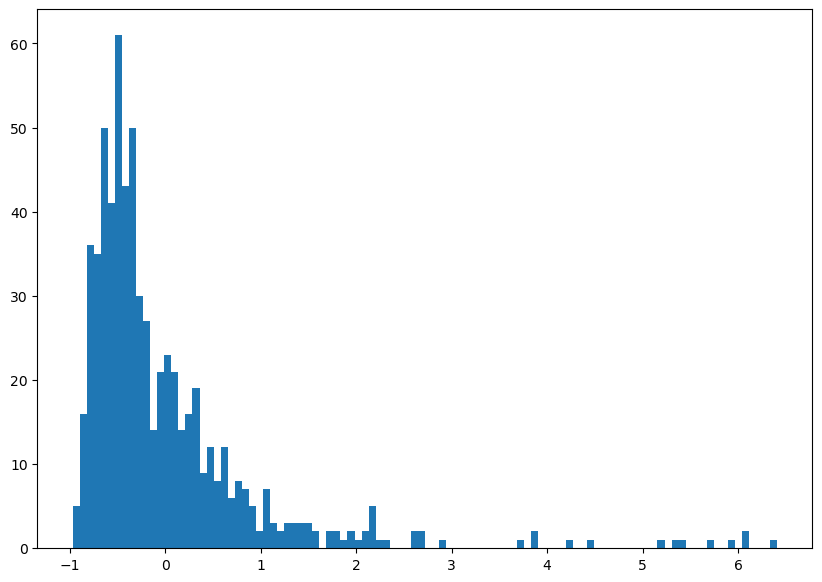

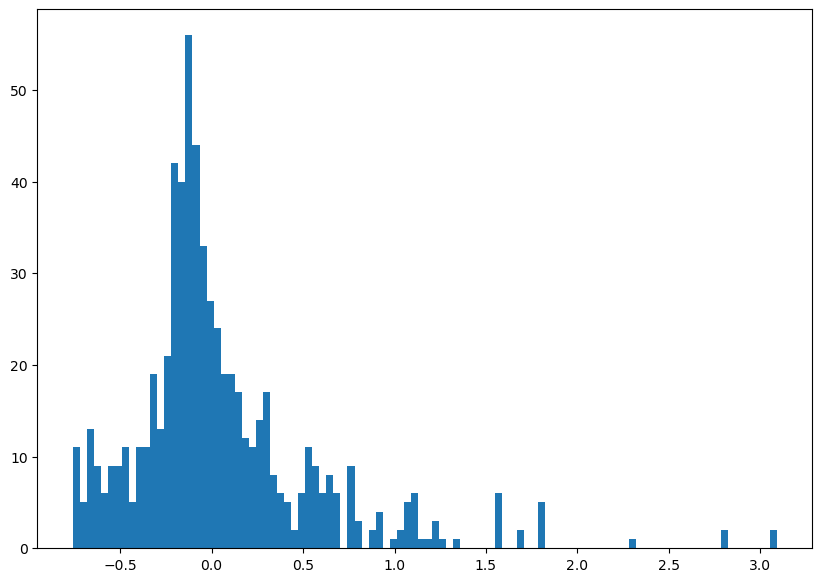

In [15]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()


r2 = pearsonr(y_true, y_preds)[0]

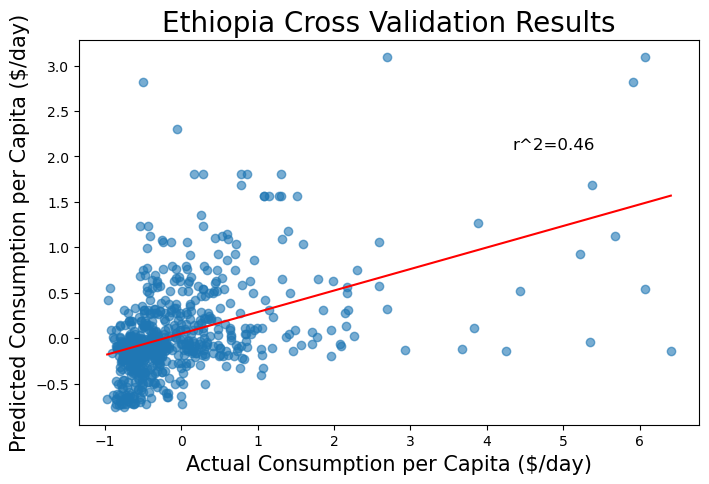

In [16]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([np.min(y_true), 10])
plt.show()